# Plot radial analysis

This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of focal events and renders various types of plots to show distributions etc


In [12]:
import calculate_radial_analysis as calculate
import dataio
import render
import numpy as np
import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [13]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.pyplot.title('Distribution of wild-type division probabiulity around Scribble apoptoses\n')

# Compile individual scans into cumulative dataframes 

In [366]:
scan_dir = '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/'#f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600'

In [367]:
cell_type = re.search('(ras|scr)',scan_dir).group()

In [368]:
files = natsorted(glob.glob(f'{scan_dir}/*'))
event_files = [file for file in files if 'N_events' in file]

In [369]:
N_events_df = dataio.feather_load_radial_df(event_files,
                                crop_amount = 20, 
                                streamline = False, 
                                remove_duplicates = {'bins':20, ### in order to remove duplicates you need to define the bins
                                                     't_range':(-10,10),
                                                     'R_max': 100}
                                           ) 

  0%|          | 0/81 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 80


In [370]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,y,x,Time since apoptosis,Focal ID
0,389,50.000000,53,113,318,-9.400000,ND0014_Pos5_mut_-11
1,451,52.333333,69,84,387,-8.333333,ND0014_Pos5_mut_-11
2,571,29.000000,96,313,327,-6.533333,ND0014_Pos5_mut_-11
3,713,73.333333,116,91,541,-5.200000,ND0014_Pos5_mut_-11
4,849,50.666667,131,99,326,-4.200000,ND0014_Pos5_mut_-11
...,...,...,...,...,...,...,...
2464,4415,64.000000,1102,1251,211,-2.266667,ND0025_Pos7_mut_-958
2465,2574,73.000000,1134,1030,236,-0.133333,ND0025_Pos7_mut_-958
2466,4527,47.000000,1125,1133,190,-0.733333,ND0025_Pos7_mut_-958
2467,4574,59.333333,1137,1272,205,0.066667,ND0025_Pos7_mut_-958


Text(0, 0.5, 'y (pixels)')

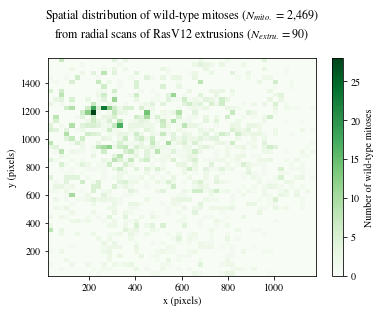

In [371]:
bins = 50
N_events, xedges, yedges, _ = plt.hist2d(N_events_df['x'], N_events_df['y'],
                                          bins=bins,)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens',)
plt.colorbar(label = 'Number of wild-type mitoses')
title = 'Spatial distribution of wild-type mitoses ($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') \nfrom radial scans of RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title)#f'Spatial distribution of wild-type divisions (n = {"{:,}".format(len(N_events_df))})\n around ')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
#plt.savefig(f'./updated_radial_results/spatial_dist_mitoses_around_{cell_type}.jpg', bbox_inches = 'tight', dpi = 314)

In [372]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,y,x,Time since apoptosis,Focal ID
0,389,50.000000,53,113,318,-9.400000,ND0014_Pos5_mut_-11
1,451,52.333333,69,84,387,-8.333333,ND0014_Pos5_mut_-11
2,571,29.000000,96,313,327,-6.533333,ND0014_Pos5_mut_-11
3,713,73.333333,116,91,541,-5.200000,ND0014_Pos5_mut_-11
4,849,50.666667,131,99,326,-4.200000,ND0014_Pos5_mut_-11
...,...,...,...,...,...,...,...
2464,4415,64.000000,1102,1251,211,-2.266667,ND0025_Pos7_mut_-958
2465,2574,73.000000,1134,1030,236,-0.133333,ND0025_Pos7_mut_-958
2466,4527,47.000000,1125,1133,190,-0.733333,ND0025_Pos7_mut_-958
2467,4574,59.333333,1137,1272,205,0.066667,ND0025_Pos7_mut_-958


Text(0, 0.5, 'y (pixels)')

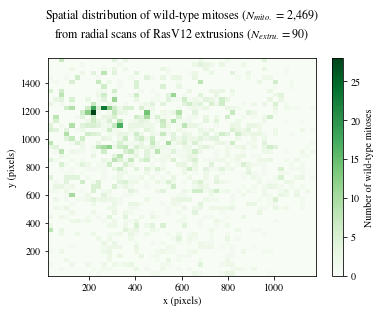

In [373]:
bins = 50
N_events, xedges, yedges, _ = plt.hist2d(N_events_df['x'], N_events_df['y'],
                                          bins=bins,)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens',)
plt.colorbar(label = 'Number of wild-type mitoses')
title = 'Spatial distribution of wild-type mitoses ($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') \nfrom radial scans of RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title)#f'Spatial distribution of wild-type divisions (n = {"{:,}".format(len(N_events_df))})\n around ')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
#plt.savefig(f'./updated_radial_results/spatial_dist_mitoses_around_{cell_type}.jpg', bbox_inches = 'tight', dpi = 314)

(array([ 22.,  23.,  29.,  62., 204., 425., 520., 619., 442., 123.]),
 array([15.0, 159.9, 304.8, 449.70000000000005, 594.6, 739.5,
        884.4000000000001, 1029.3000000000002, 1174.2, 1319.1000000000001,
        1464.0], dtype=object),
 <BarContainer object of 10 artists>)

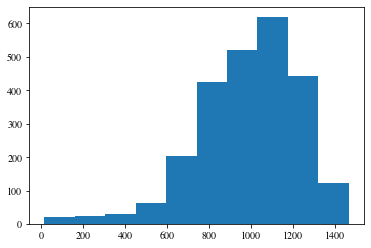

In [374]:
plt.hist(N_events_df['Frame'])

### Loading cell counts for probability plot

Might need to be streamlined for full list

In [375]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [376]:
cell_count_files

['/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/ND0014_Pos5_mut_-11_N_cells_wt_rad_1600_t_range_1600_focal_txy_194_230_361.feather',
 '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/ND0014_Pos5_mut_-488_N_cells_wt_rad_1600_t_range_1600_focal_txy_276_433_390.feather',
 '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/ND0014_Pos5_mut_-1317_N_cells_wt_rad_1600_t_range_1600_focal_txy_592_40_897.feather',
 '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/ND0014_Pos5_mut_-2535_N_cells_wt_rad_1600_t_range_1600_focal_txy_898_698_77.feather',
 '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/ND0014_Pos7_mut_-1_N_cells_wt_rad_1600_t_range_1600_focal_txy_145_1130_434.feather',
 '/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras

In [549]:
N_cells_df = dataio.feather_load_radial_df(cell_count_files,
                                crop_amount = 20, 
                                streamline = False, 
                                remove_duplicates = {'bins':10, ### in order to remove duplicates you need to define the bins
                                                     't_range':(-10,10),
                                                     'R_max': 300}
                                          ) 

  0%|          | 0/91 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 90


Text(0, 0.5, 'y (pixels)')

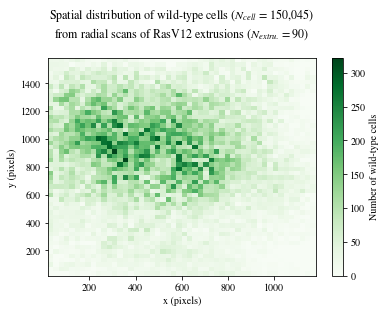

In [261]:
N_cells, xedges, yedges, _ = plt.hist2d(N_cells_df['x'], N_cells_df['y'],
                  bins=50,)
pc = plt.pcolormesh(xedges, yedges, N_cells.T, cmap = 'Greens')
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatial distribution of wild-type cells ($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') \nfrom radial scans of RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title)#f'Spatial distribution of wild-type cells (n = {"{:,}".format(len(N_cells_df))})\n')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
#plt.savefig(f'./updated_radial_results/spatial_dist_cells_around_{cell_type}.jpg', bbox_inches = 'tight', dpi = 314)

(array([ 645781., 1271964., 2377987., 4357851., 6687340., 9379410.,
        5808983., 2150470., 1701129., 1131176.]),
 array([   0. ,  207.3,  414.6,  621.9,  829.2, 1036.5, 1243.8, 1451.1,
        1658.4, 1865.7, 2073. ]),
 <BarContainer object of 10 artists>)

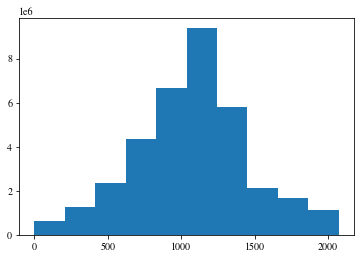

In [239]:
plt.hist(N_cells_df['Frame'])

In [300]:
N_cells_df

,Cell ID,Distance from apoptosis,Frame,y,x,Time since apoptosis,Focal ID
0,60,78.000000,0,247,177,-12.933333,ND0014_Pos5_mut_-11
1,69,410.000000,0,1422,33,-12.933333,ND0014_Pos5_mut_-11
2,68,374.333333,0,1313,44,-12.933333,ND0014_Pos5_mut_-11
3,67,359.666667,0,1269,52,-12.933333,ND0014_Pos5_mut_-11
4,66,347.333333,0,1229,50,-12.933333,ND0014_Pos5_mut_-11
...,...,...,...,...,...,...,...
35512086,4885,45.666667,1181,1123,190,3.000000,ND0025_Pos7_mut_-958
35512087,4887,95.666667,1181,881,89,3.000000,ND0025_Pos7_mut_-958
35512088,4892,386.000000,1181,766,1147,3.000000,ND0025_Pos7_mut_-958
35512089,4893,54.000000,1181,1225,212,3.000000,ND0025_Pos7_mut_-958


# Plotting the spatiotemporal distribution ratio of events to appearances 

`P_events = N_events/N_cells`

In [241]:
import importlib
importlib.reload(dataio)

<module 'dataio' from '/home/nathan/analysis/cell-comp-analysis/radial_analysis/dataio.py'>

In [551]:
t_range = (-10,10)
R_range = (0,300)
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render.render_from_df(N_events_df, N_cells_df, bins, t_range, R_range)

<Figure size 432x288 with 0 Axes>

In [243]:
xedges

array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.])

In [244]:
yedges

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [245]:
len(set(N_cells_df['Focal ID']))

90

In [246]:
"{:,}".format(5000000)

'5,000,000'

In [247]:
title = 'Spatio-temporal distribution of wild-type cells \n($N_{cell}$ =' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} =$' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '


In [248]:
title

'Spatio-temporal distribution of wild-type cells \n($N_{cell}$ =35,512,091) around RasV12 extrusions ($N_{extru.} =$90) \n '

Text(0, 0.5, 'Distance from extrusion (μm)')

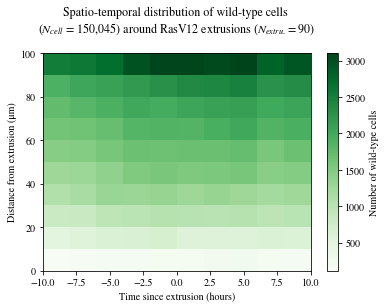

In [379]:
pc = plt.pcolormesh(xedges, yedges, N_cells.T,
                    cmap = 'Greens',           
                    shading='auto'
                   )
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatio-temporal distribution of wild-type cells \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/N_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

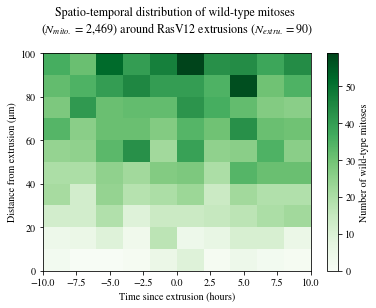

In [380]:
pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens',)
plt.colorbar(label = 'Number of wild-type mitoses')
title = 'Spatio-temporal distribution of wild-type mitoses \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/N_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

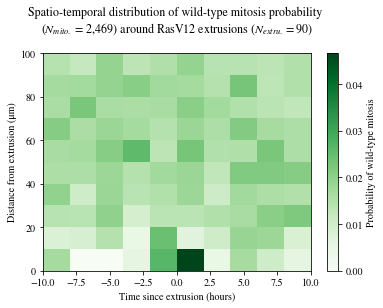

In [381]:
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Greens',)
plt.colorbar(label = 'Probability of wild-type mitosis')
title = 'Spatio-temporal distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/P_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

### density

In [470]:
def densify_dist(dist_2d, spatial_bins):
    radial_areas = (spatial_bins**2)*np.pi
    rad_ring_areas = np.stack([int(radial_areas[n]-radial_areas[n-1]) for n in range(1, len(radial_areas))])
    density_dist = dist_2d/rad_ring_areas
    return density_dist

In [525]:
np.mean(densify_dist(N_cells, yedges))

0.34206410855224834

Text(0, 0.5, 'Distance from extrusion (μm)')

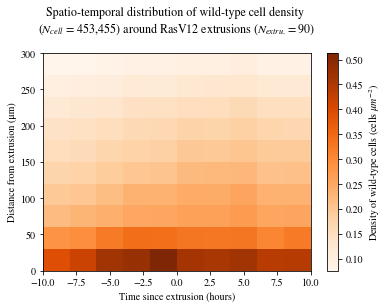

In [552]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_cells, yedges).T,
                    cmap = 'Oranges',           
                    shading='auto'
                   )
plt.colorbar(label = 'Density of wild-type cells (cells $\mu m^{-2}$)')
title = 'Spatio-temporal distribution of wild-type cell density \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/D_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

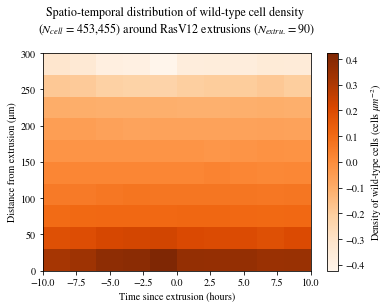

In [553]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_cells, yedges).T- np.flipud(densify_dist(N_cells, yedges).T),
                    cmap = 'Oranges',           
                    shading='auto'
                   )
plt.colorbar(label = 'Density of wild-type cells (cells $\mu m^{-2}$)')
title = 'Spatio-temporal distribution of wild-type cell density \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/D_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

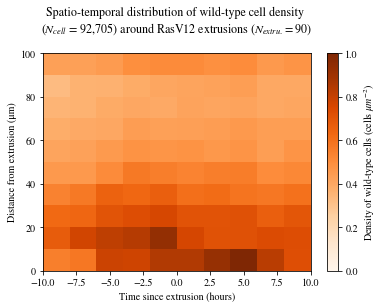

In [540]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_cells, yedges).T/np.max(densify_dist(N_cells, yedges).T),
                    cmap = 'Oranges',           
                    shading='auto',
                    norm=matplotlib.colors.Normalize(vmin=0, vmax=1)
                   )
plt.colorbar(label = 'Density of wild-type cells (cells $\mu m^{-2}$)')
title = 'Spatio-temporal distribution of wild-type cell density \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/D_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

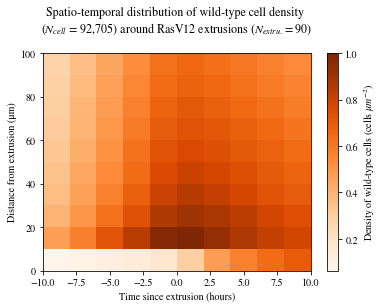

In [539]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_cells_c, yedges).T/np.max(densify_dist(N_cells_c, yedges).T),
                    cmap = 'Oranges',           
                    shading='auto',
                  #  norm=matplotlib.colors.Normalize(vmin=0, vmax=1)
                   )
plt.colorbar(label = 'Density of wild-type cells (cells $\mu m^{-2}$)')
title = 'Spatio-temporal distribution of wild-type cell density \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/D_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

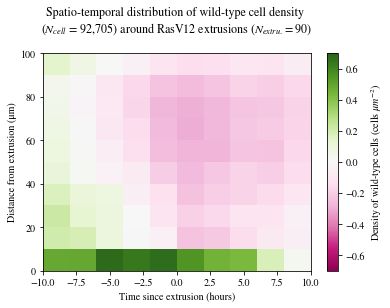

In [548]:
pc = plt.pcolormesh(xedges, yedges, (densify_dist(N_cells, yedges).T/np.max(densify_dist(N_cells, yedges).T)) - (densify_dist(N_cells_c, yedges).T/np.max(densify_dist(N_cells_c, yedges).T)),
                    cmap = 'PiYG',           
                    shading='auto',
                   norm=matplotlib.colors.Normalize(vmin=-0.7, vmax=0.7)
                   )
plt.colorbar(label = 'Density of wild-type cells (cells $\mu m^{-2}$)')
title = 'Spatio-temporal distribution of wild-type cell density \n($N_{cell}$ = ' + "{:,}".format(len(N_cells_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/D_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from extrusion (μm)')

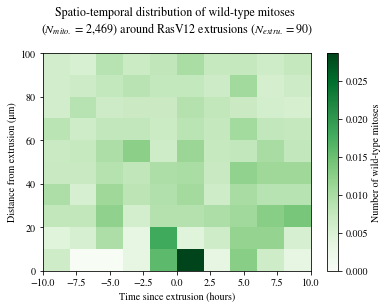

In [471]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_events, yedges).T, cmap = 'Greens',)
plt.colorbar(label = 'Number of wild-type mitoses')
title = 'Spatio-temporal distribution of wild-type mitoses \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n '
plt.title(title) #'Spatio-temporal distribution of wild-type cells \n($N_{cell} = 150,045$) around RasV12 extrusions ($N_{extru.} = 90$) \n ')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/N_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Processed

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [382]:
control_scan_dir = f'/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/controlv2/'

In [383]:
control_files = natsorted(glob.glob(f'{control_scan_dir}/*.feather'))
control_event_files = [file for file in control_files if 'N_events' in file]
control_cell_count_files = [file for file in control_files if 'N_cells' in file]

In [384]:
control_N_events_df = dataio.feather_load_radial_df(control_event_files,#[0:1000],                                    
                                                     crop_amount = 20, 
                                                     streamline = False, 
#                                                    remove_duplicates = {'bins':10, ### in order to remove duplicates you need to define the bins
#                                                         't_range':(-10,10),
#                                                         'R_max': 100}
                                                   ) ### N_cells is large so streamlining advised

  0%|          | 0/3316 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 2684


In [385]:
control_N_cells_df = dataio.feather_load_radial_df(control_cell_count_files,#[0:1000],                                    
                                                     crop_amount = 20, 
                                                     streamline = False, 
#                                                    remove_duplicates = {'bins':10, ### in order to remove duplicates you need to define the bins
#                                                         't_range':(-10,10),
#                                                         'R_max': 100}
                                                  ) ### N_cells is large so streamlining advised

  0%|          | 0/3740 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 3186


In [476]:
t_range = (-10,10)
R_range = (0,100)
bins = (10,10)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render.render_from_df(control_N_events_df, control_N_cells_df, bins, t_range, R_range)

<Figure size 432x288 with 0 Axes>

In [387]:
control_N_cells_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis,Focal ID
0,10648,92.000000,1146,1158,791,-10.000000,ND0014_Pos5_wt_1
1,10648,91.333333,1147,1163,791,-9.933333,ND0014_Pos5_wt_1
2,10648,91.666667,1148,1161,790,-9.866667,ND0014_Pos5_wt_1
3,10648,91.333333,1149,1163,790,-9.800000,ND0014_Pos5_wt_1
4,10648,90.333333,1150,1163,790,-9.733333,ND0014_Pos5_wt_1
...,...,...,...,...,...,...,...
40621992,4122,80.666667,1181,1118,254,3.800000,ND0025_Pos7_wt_4256
40621993,4136,82.000000,1181,1149,296,3.800000,ND0025_Pos7_wt_4256
40621994,4227,95.666667,1181,1027,119,3.800000,ND0025_Pos7_wt_4256
40621995,4603,96.333333,1181,1057,246,3.800000,ND0025_Pos7_wt_4256


#### Plotting control #1

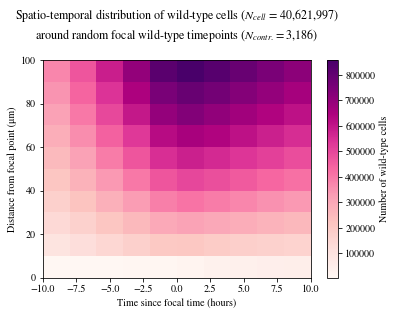

In [405]:
pc = plt.pcolormesh(xedges, yedges, N_cells_c.T,cmap = 'RdPu',)
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatio-temporal distribution of wild-type cells ($N_{cell}$ = ' + "{:,}".format(len(control_N_cells_df)) + ') \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
plt.savefig(f'./updated_radial_results/C3_N_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from focal point (μm)')

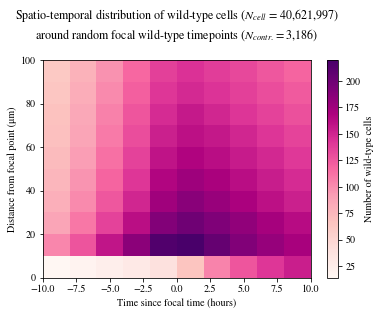

In [478]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_cells_c, yedges).T,cmap = 'RdPu',)
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatio-temporal distribution of wild-type cells ($N_{cell}$ = ' + "{:,}".format(len(control_N_cells_df)) + ') \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
#plt.savefig(f'./updated_radial_results/C3_N_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

Text(0, 0.5, 'Distance from focal point (μm)')

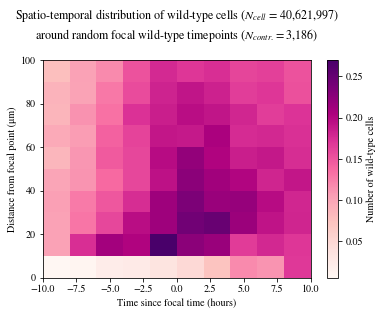

In [477]:
pc = plt.pcolormesh(xedges, yedges, densify_dist(N_events_c, yedges).T,cmap = 'RdPu',)
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatio-temporal distribution of wild-type cells ($N_{cell}$ = ' + "{:,}".format(len(control_N_cells_df)) + ') \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
#plt.savefig(f'./updated_radial_results/C3_N_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

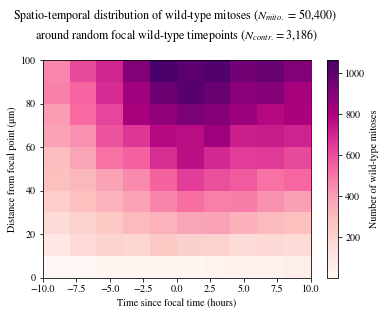

In [404]:
pc = plt.pcolormesh(xedges, yedges, N_events_c.T,cmap = 'RdPu',)
plt.colorbar(label = 'Number of wild-type mitoses')
title = 'Spatio-temporal distribution of wild-type mitoses ($N_{mito.}$ = ' + "{:,}".format(len(control_N_events_df)) + ')  \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
plt.savefig(f'./updated_radial_results/C3_N_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

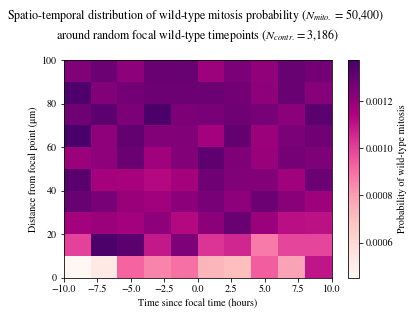

In [403]:
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'RdPu', )
plt.colorbar(label = 'Probability of wild-type mitosis')
title = 'Spatio-temporal distribution of wild-type mitosis probability ($N_{mito.}$ = ' + "{:,}".format(len(control_N_events_df)) + ')  \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
plt.savefig(f'./updated_radial_results/C3_P_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

In [292]:
disc_t_range = np.linspace(t_range[0], t_range[1], bins+1)

In [293]:
disc_t_range

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

#### Plotting probability above background for control #1

Text(0, 0.5, 'Distance from extrusion (μm)')

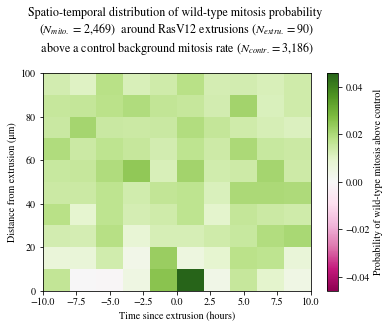

In [406]:
pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', 
                   #vmax=np.amax(P_events.T - P_events_c.T), vmin = -(np.amax(P_events.T - P_events_c.T)))
                   vmax=np.amax(abs(P_events.T - P_events_c.T)), vmin = -(np.amax(abs(P_events.T - P_events_c.T))))
plt.colorbar(label = 'Probability of wild-type mitosis above control',)
title = 'Spatio-temporal distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig(f'./updated_radial_results/P_div_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

In [482]:
from sklearn.preprocessing import normalize

Text(0, 0.5, 'Distance from focal point (μm)')

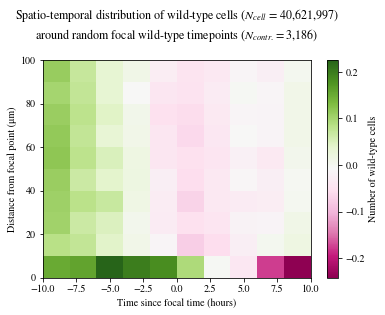

In [484]:
pc = plt.pcolormesh(xedges, yedges, normalize(densify_dist(N_cells, yedges).T) - normalize(densify_dist(N_cells_c, yedges).T),cmap = 'PiYG',)
plt.colorbar(label = 'Number of wild-type cells')
title = 'Spatio-temporal distribution of wild-type cells ($N_{cell}$ = ' + "{:,}".format(len(control_N_cells_df)) + ') \naround random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since focal time (hours)')
plt.ylabel('Distance from focal point (μm)')
#plt.savefig(f'./updated_radial_results/C3_N_cell_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

# Coefficient of variation



In [395]:
t_range = (-10,10)
R_range = (0,100)
bins = (10,10)

P_events, xedges, yedges,  N_events, N_cells = render.render_from_df(N_events_df, N_cells_df, bins, t_range, R_range)
#P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_range)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render.render_from_df(control_N_events_df, control_N_cells_df, bins, t_range, R_range)

<Figure size 432x288 with 0 Axes>

In [292]:
import numpy as np

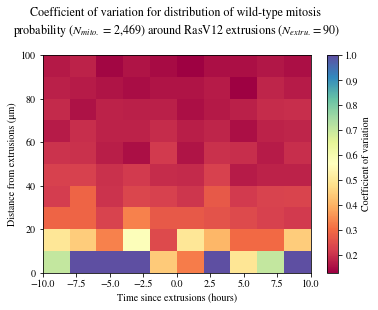

In [409]:
cv = np.nan_to_num(np.sqrt((1 - P_events) / (P_events * N_cells)), posinf=1)
pc = plt.pcolormesh(xedges, yedges, cv.T, cmap = 'Spectral', )
plt.colorbar(label = 'Coefficient of variation',)
plt.title('Coefficient of variation for distribution of wild-type mitosis \nprobability ($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n ')
plt.ylabel('Distance from extrusions (μm)')
plt.xlabel('Time since extrusions (hours)')
plt.savefig(f'./updated_radial_results/CV_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

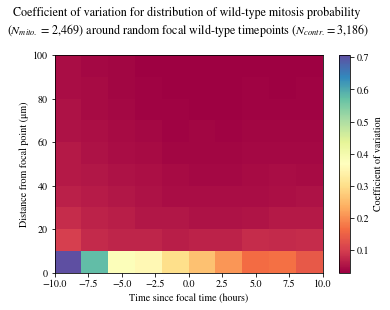

In [410]:
cv_c = np.nan_to_num(np.sqrt((1 - P_events_c) / (P_events_c * N_cells_c)), posinf=1)
pc = plt.pcolormesh(xedges, yedges, cv_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Coefficient of variation',)
plt.title('Coefficient of variation for distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ') around random focal wild-type timepoints ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n ')
plt.ylabel('Distance from focal point (μm)')
plt.xlabel('Time since focal time (hours)')
plt.savefig(f'./updated_radial_results/CV_C3_P_div_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

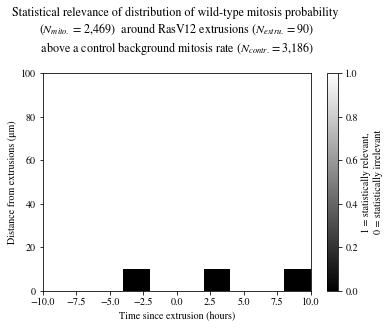

In [411]:
stat_rel = calculate.stat_relevance_calc(bins, P_events, P_events_c, cv, cv_c)
pc = plt.pcolormesh(xedges, yedges, stat_rel.T, cmap = 'gray', )
plt.colorbar(label = '1 = statistically relevant, \n0 = statistically irrelevant')
plt.title('Statistical relevance of distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n ')
plt.ylabel('Distance from extrusions (μm)')
plt.xlabel('Time since extrusion (hours)')
plt.savefig(f'./updated_radial_results/stat_rel_P_div_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

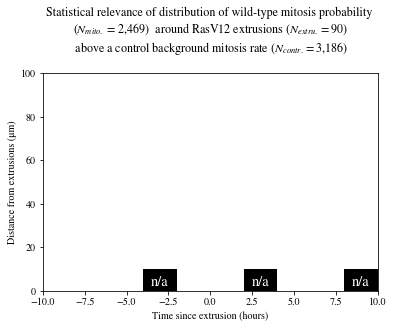

In [412]:
stat_rel = calculate.stat_relevance_calc(bins, P_events, P_events_c, cv, cv_c)
pc = plt.pcolormesh(xedges, yedges, stat_rel.T, cmap = 'gray', )
#plt.colorbar(label = '1 = statistically relevant, \n0 = statistically irrelevant')
plt.title('Statistical relevance of distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n ')
plt.ylabel('Distance from extrusions (μm)')
plt.xlabel('Time since extrusion (hours)')
data = P_div_rel.T
for i, y in enumerate(yedges):
    for j, x in enumerate(xedges):
        if j == min(bins) or i == min(bins):
            break
        if stat_rel.T[i, j] == 0:
            plt.text(x +1 , y +4, 'n/a',#'null', #%.4f' % data[y, x],
                     horizontalalignment='center',verticalalignment='center',fontsize = 'x-large',c = 'white')
#         else:
#             plt.text(x +1 , y +4, 'valid',#'null', #%.4f' % data[y, x],
#                      horizontalalignment='center',verticalalignment='center',fontsize = 'x-large',c = 'black')
plt.savefig(f'./updated_radial_results/alt_stat_rel_P_div_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

# convolving the pdiv abv bg with stat rel

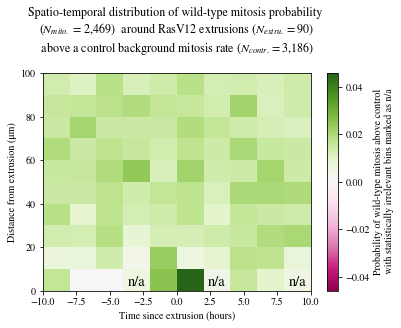

In [416]:
P_div_rel = (P_events - P_events_c)
pc = plt.pcolormesh(xedges, yedges, P_div_rel.T, cmap = 'PiYG', 
                   #vmax=np.amax(P_events.T - P_events_c.T), vmin = -(np.amax(P_events.T - P_events_c.T)))
                   vmax=np.amax(abs(P_events.T - P_events_c.T)), vmin = -(np.amax(abs(P_events.T - P_events_c.T))))
plt.colorbar(label = 'Probability of wild-type mitosis above control\n with statistically irrelevant bins marked as n/a',)
title = 'Spatio-temporal distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') \n '
plt.title(title)
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')

data = P_div_rel.T
for i, y in enumerate(yedges):
    for j, x in enumerate(xedges):
        if j == min(bins) or i == min(bins):
            break
        if stat_rel.T[i, j] == 0:
            plt.text(x +1 , y +4, 'n/a',#'null', #%.4f' % data[y, x],
                     horizontalalignment='center',verticalalignment='center',fontsize = 'x-large',c = 'black')
plt.savefig(f'./updated_radial_results/stat_rel_P_div_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

just with stat irrelavant areas zeroed (misleading imo)

Text(0, 0.5, 'Distance from extrusion (μm)')

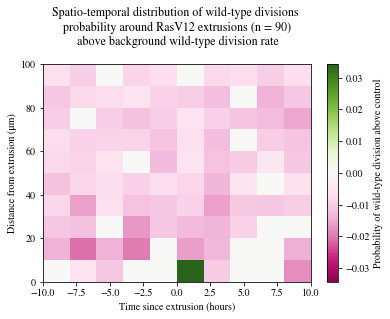

In [71]:
P_div_rel = stat_rel * (P_events - P_events_c)
pc = plt.pcolormesh(xedges, yedges, P_div_rel.T, cmap = 'PiYG', 
                   #vmax=np.amax(P_events.T - P_events_c.T), vmin = -(np.amax(P_events.T - P_events_c.T)))
                   vmax=np.amax(abs(P_events.T - P_events_c.T)), vmin = -(np.amax(abs(P_events.T - P_events_c.T))))
plt.colorbar(label = 'Probability of wild-type division above control',)
plt.title('Spatio-temporal distribution of wild-type divisions \nprobability around RasV12 extrusions (n = 90)\n above background wild-type division rate\n')
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')
#plt.savefig('./updated_radial_results/P_div above bg wt:ras control3 100.10.10.5.jpg', bbox_inches = 'tight', dpi = 314)

### other labelled plots

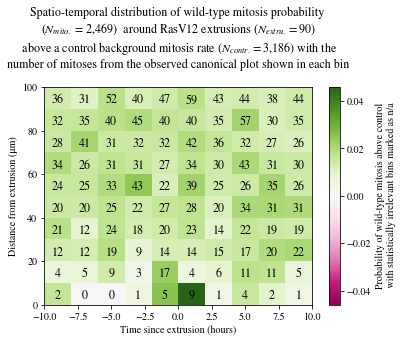

In [414]:
P_div_rel = (P_events - P_events_c)
pc = plt.pcolormesh(xedges, yedges, P_div_rel.T, cmap = 'PiYG', 
                   #vmax=np.amax(P_events.T - P_events_c.T), vmin = -(np.amax(P_events.T - P_events_c.T)))
                   vmax=np.amax(abs(P_events.T - P_events_c.T)), vmin = -(np.amax(abs(P_events.T - P_events_c.T))))
plt.colorbar(label = 'Probability of wild-type mitosis above control\n with statistically irrelevant bins marked as n/a',)
title = 'Spatio-temporal distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') with the \nnumber of mitoses from the observed canonical plot shown in each bin\n '
plt.title(title)
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')

data = P_div_rel.T
for i, y in enumerate(yedges):
    for j, x in enumerate(xedges):
        if j == min(bins) or i == min(bins):
            break
#         if stat_rel.T[i, j] == 0:
        N = N_events.T[i,j]
        plt.text(x +1 , y +4, int(N),#'null', #%.4f' % data[y, x],
                     horizontalalignment='center',verticalalignment='center',fontsize = 'large',c = 'black')
plt.savefig(f'./updated_radial_results/stat_rel_P_div_N_div_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

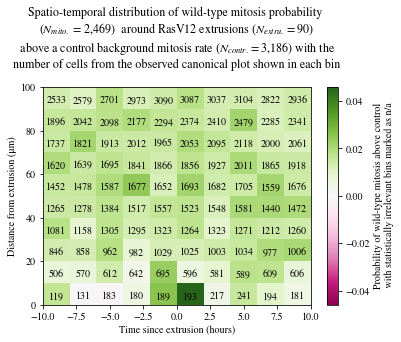

In [415]:
P_div_rel = (P_events - P_events_c)
pc = plt.pcolormesh(xedges, yedges, P_div_rel.T, cmap = 'PiYG', 
                   #vmax=np.amax(P_events.T - P_events_c.T), vmin = -(np.amax(P_events.T - P_events_c.T)))
                   vmax=np.amax(abs(P_events.T - P_events_c.T)), vmin = -(np.amax(abs(P_events.T - P_events_c.T))))
plt.colorbar(label = 'Probability of wild-type mitosis above control\n with statistically irrelevant bins marked as n/a',)
title = 'Spatio-temporal distribution of wild-type mitosis probability \n($N_{mito.}$ = ' + "{:,}".format(len(N_events_df)) + ')  around RasV12 extrusions ($N_{extru.} = $' + "{:,}".format(len(set(N_cells_df['Focal ID']))) + ') \n above a control background mitosis rate ($N_{contr.} = $' + "{:,}".format(len(set(control_N_cells_df['Focal ID']))) + ') with the \nnumber of cells from the observed canonical plot shown in each bin\n '
plt.title(title)
plt.xlabel('Time since extrusion (hours)')
plt.ylabel('Distance from extrusion (μm)')

data = P_div_rel.T
for i, y in enumerate(yedges):
    for j, x in enumerate(xedges):
        if j == min(bins) or i == min(bins):
            break
#         if stat_rel.T[i, j] == 0:
        N = N_cells.T[i,j]
        plt.text(x +1 , y +4, int(N),#'null', #%.4f' % data[y, x],
                     horizontalalignment='center',verticalalignment='center',fontsize = 'medium',c = 'black')
plt.savefig(f'./updated_radial_results/stat_rel_P_div_N_cell_ab_bg_control_wt:{cell_type}_{R_range}_{t_range}_{bins}.jpg', bbox_inches = 'tight', dpi = 314)

In [363]:
len(set([i.split('_mut')[0] for i in list(set(N_cells_df['Focal ID']))]))

22

In [364]:
set([i.split('_mut')[0] for i in list(set(N_cells_df['Focal ID']))])

{'ND0014_Pos5',
 'ND0014_Pos7',
 'ND0014_Pos8',
 'ND0014_Pos9',
 'ND0017_Pos7',
 'ND0021_Pos4',
 'ND0021_Pos7',
 'ND0022_Pos3',
 'ND0022_Pos4',
 'ND0022_Pos5',
 'ND0022_Pos6',
 'ND0022_Pos7',
 'ND0024_Pos3',
 'ND0024_Pos4',
 'ND0024_Pos5',
 'ND0024_Pos6',
 'ND0024_Pos7',
 'ND0025_Pos3',
 'ND0025_Pos4',
 'ND0025_Pos5',
 'ND0025_Pos6',
 'ND0025_Pos7'}